In [108]:
import numpy as np
import matplotlib.pyplot as plt
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
import compute_S_rate
import auxiliary_functions
import seaborn
import math

import networkx as nx

In [3]:
def Discrete_RW_T(A):    # Calculate the degree vector (sum of non-zero elements in each row)
    degree_vector = np.array(A.sum(axis=1)).ravel()

    # Avoid division by zero by setting degree to 1 for nodes with no edges
    no_out_edges = degree_vector == 0
    degree_vector[no_out_edges] = 1.0

    # Create a diagonal matrix from the inverted degree vector
    degree_matrix = np.diag(1.0 / degree_vector)

    # Calculate the random walk Transition matrix: T = D^(-1) * A
    T = degree_matrix @ A
    np.fill_diagonal(T, no_out_edges, wrap=False)
    return T

# ER Graphs

In [51]:
N= 1000
p = 0.005
er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(N, p))
T = Discrete_RW_T(er_adj)
times = [1, 2, 3, 4, 5, 7, 9, 12, 15]

list_power_T = []
for t in times:
    power_T = np.linalg.matrix_power(T, t)
    list_power_T.append(power_T)

In [52]:
list_number_connected_nodes = []
for power in list_power_T:
    connected_nodes = power > 0
    list_number_connected_nodes.append(np.sum(connected_nodes, axis=1))

In [53]:
# Shell approximation
list_shell = []
shell = 1
sum_shells = 0

for t in times:
    while shell <= t:
        if sum_shells + pow((N - sum_shells) * p, shell) < N:
            sum_shells += pow((N - sum_shells) * p, shell)
            shell += 1
        else:
            sum_shells = N
            list_shell.append(sum_shells)
            shell += 1
    list_shell.append(sum_shells)

In [54]:
list_shell

[5.0,
 29.750625000000007,
 143.92276147434626,
 479.6076706873247,
 598.870320232311,
 701.7635830129714,
 743.0952593299935,
 771.611913324804,
 785.4574829731534]

In [147]:
def branching_levels_with_parity(c, N):
    levels = []              # List to store reachable nodes at each level
    total_nodes = 1          # Total number of nodes so far (starts with the root)
    nodes_at_level = [1]     # Nodes at level 0 (the root)
    
    level = 1                # Start calculating from level 1
    while total_nodes < N:
        
        # Calculate new nodes added by expanding reachable nodes
        new_nodes = min(nodes_at_level[-1]*c, N - total_nodes)
        
        # Add to the list of nodes at the current level
        nodes_at_level.append(new_nodes)
        
        # Update the total nodes count
        total_nodes += new_nodes
        
        
        # Nodes reachable at this level considering parity (only previous levels with same parity)
        reachable_nodes = sum(nodes_at_level[i] for i in range(0, level, 2))
        levels.append(reachable_nodes)

        # Move to the next level
        level += 1
    return levels

In [148]:
list_parity_shell = branching_levels_with_parity(N*p, N)
print(list_parity_shell)

[1, 1, 26.0, 26.0, 651.0]


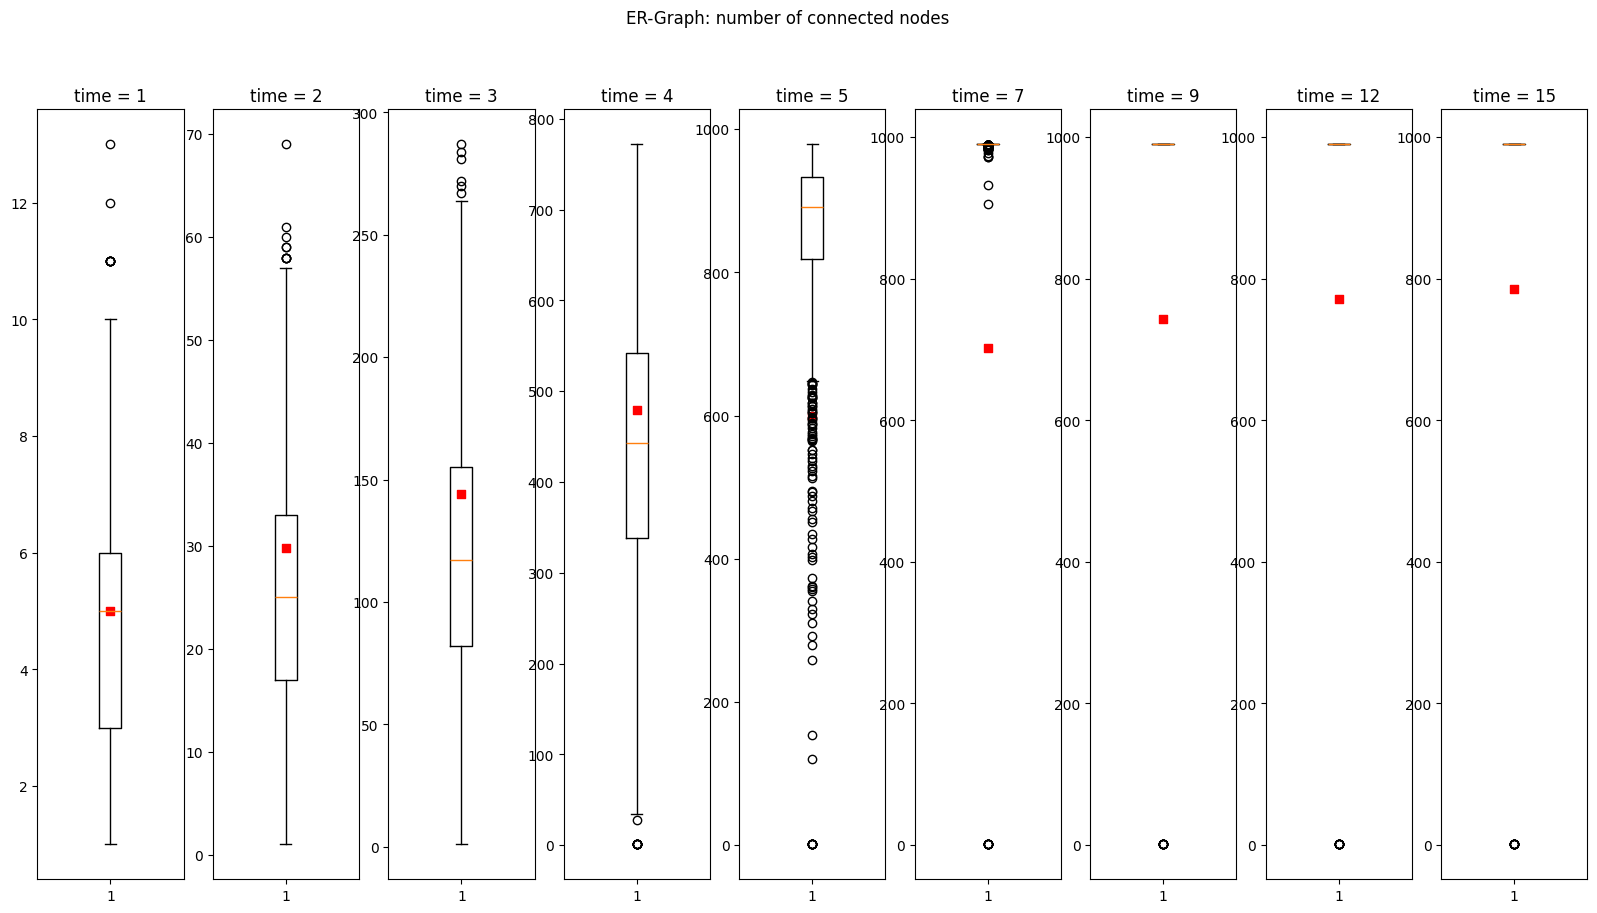

In [55]:
fig, ax = plt.subplots(1,len(times), figsize=(20,10))
for i in range(len(times)):
    ax[i].boxplot(list_number_connected_nodes[i])
    ax[i].scatter(1, list_shell[i], color='r', marker='s')
    ax[i].set_title('time = ' + str(times[i]))
fig.suptitle('ER-Graph: number of connected nodes')
plt.show()

### Comparison between entropy values

In [74]:
p0 = 1/N*np.ones(N)

n_edges = er_adj.toarray().sum() / 2
degrees = er_adj.toarray().sum(0)
pi_0 = degrees / (2*n_edges)


avg_degree = np.mean(degrees)
corrected_degrees  = np.where(degrees > 0, degrees, 1)
avg_degreelogdegree = np.mean(degrees * np.log(corrected_degrees))
asymptot = np.log(2 * n_edges) - avg_degreelogdegree / avg_degree


In [75]:
#actual conditional entropy

list_H_er = [0]
for power_T in list_power_T:
    logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
    powTlogpowTdata = power_T * logpowTdata
    rows_entropies = -np.sum(powTlogpowTdata, axis=1)
    H_er = np.dot(p0, rows_entropies)
    list_H_er.append(H_er)

In [76]:
#entropy with our estimate of shell + uniform assumption
list_H_approximated_shells = [0]
for i in range(len(times)):
    list_H_approximated_shells.append(min(asymptot, np.log(list_shell[i])))

In [102]:
#entropy with our average real shell + uniform assumption
list_H_averagereal_shells = [0]
for  i in range(len(times)):
    shell_size = np.mean(list_number_connected_nodes[i])
    list_H_averagereal_shells.append(min(asymptot, np.log(shell_size)))

In [103]:
#entropy with our  real shell + uniform assumption
list_H_real_shells = [0]
for  i in range(len(times)):
    log_shell_size = np.log(list_number_connected_nodes[i])
    list_H_real_shells.append(min(asymptot,np.dot(p0, log_shell_size)))

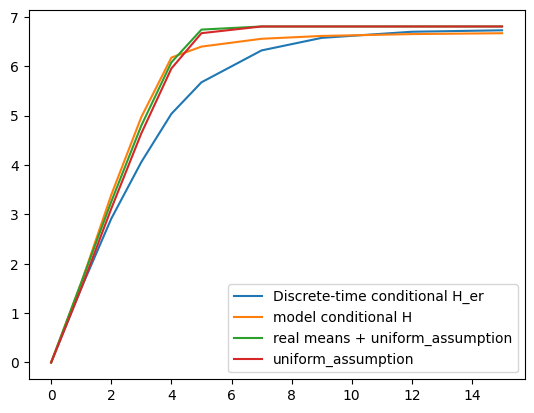

In [106]:
plt.plot([0] + times, list_H_er, label = 'Discrete-time conditional H_er')
plt.plot([0] + times, list_H_approximated_shells, label = 'model conditional H')
plt.plot([0] + times, list_H_averagereal_shells, label = 'real means + uniform_assumption')
plt.plot([0] + times, list_H_real_shells, label = 'uniform_assumption')
plt.legend()
#plt.savefig('/home/b/skoove/Desktop/plots_entropy/conditional_entropyER.png', format='png', dpi=300)
plt.show()

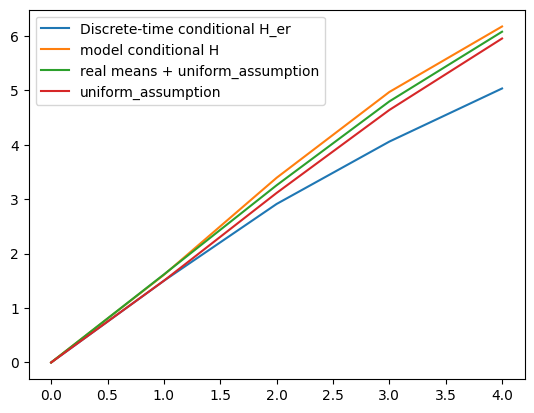

In [107]:
plt.plot([0] + times[0:4], list_H_er[0:5], label = 'Discrete-time conditional H_er')
plt.plot([0] + times[0:4], list_H_approximated_shells[0:5], label = 'model conditional H')
plt.plot([0] + times[0:4], list_H_averagereal_shells[0:5], label = 'real means + uniform_assumption')
plt.plot([0] + times[0:4], list_H_real_shells[0:5], label = 'uniform_assumption')
plt.legend()
#plt.savefig('/home/b/skoove/Desktop/plots_entropy/conditional_entropyER.png', format='png', dpi=300)
plt.show()

This graph shows that the difference is mainly caused by the uniform assumption, and that the approximation of the shell sizes is less harmful

## Using degree distribution instead of uniform assumption

In [122]:
list_H_degree_distr = [0]
for  i in range(len(times)):
    shell_size = np.mean(list_number_connected_nodes[i])
    #sample degrees > 0
    sample_degrees = np.random.choice(degrees[degrees > 0], size=int(shell_size))
    normalizing_const = np.sum(sample_degrees)
    degrees_distr = [i / normalizing_const for i in sample_degrees]
    list_H_degree_distr.append(min(asymptot,- np.dot(degrees_distr, np.log(degrees_distr))))
    

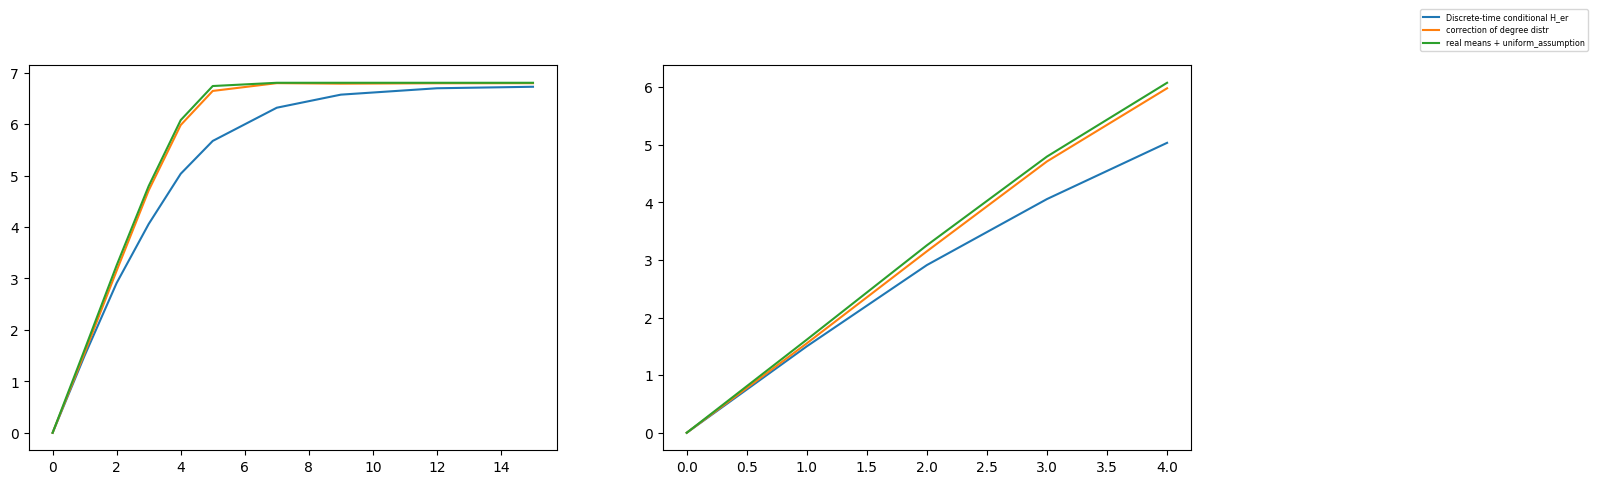

In [123]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot([0] + times, list_H_er, label = 'Discrete-time conditional H_er')
ax[0].plot([0] + times, list_H_degree_distr, label = 'correction of degree distr')
ax[0].plot([0] + times, list_H_averagereal_shells, label = 'real means + uniform_assumption')

ax[1].plot([0] + times[0:4], list_H_er[0:5])
ax[1].plot([0] + times[0:4], list_H_degree_distr[0:5])
ax[1].plot([0] + times[0:4], list_H_averagereal_shells[0:5])

fig.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
#plt.savefig('/home/b/skoove/Desktop/plots_entropy/conditional_entropyER.png', format='png', dpi=300)
plt.show()

Correction of the uniform assumption by taking degree distribution does not work.

# Configuration Model

In [124]:
# Step 1: Generate power-law distributed degree sequence
N = 1000  # Number of nodes
gamma = 2.1  # Power law exponent

# Using a minimum degree of 1 and generating the degree sequence
degree_sequence = np.random.zipf(gamma, N)

# Step 2: Ensure the degree sequence sum is even
if sum(degree_sequence) % 2 != 0:
    # If the sum is odd, make the first degree odd/even to correct it
    degree_sequence[0] += 1

# Step 3: Create the configuration model
G = nx.configuration_model(degree_sequence)

# Step 4: Remove parallel edges and self-loops (optional)
G = nx.Graph(G)  # This removes parallel edges
G.remove_edges_from(nx.selfloop_edges(G))  # Remove self-loops

cm_adj = nx.adjacency_matrix(G)
T_cm = Discrete_RW_T(cm_adj)

In [125]:

list_power_T_cm = []
for t in times:
    power_T_cm = np.linalg.matrix_power(T_cm, t)
    list_power_T_cm.append(power_T_cm)

In [126]:
list_number_connected_nodes_cm = []
for power in list_power_T_cm:
    connected_nodes = power > 0
    list_number_connected_nodes_cm.append(np.sum(connected_nodes, axis=1))

In [127]:
degrees_cm = cm_adj.toarray().sum(0)
mean_degree_cm = np.mean(degrees_cm)


excess_degree = (np.mean(np.square(degrees_cm)) - mean_degree_cm) / mean_degree_cm

In [128]:
print(mean_degree_cm)
print(excess_degree)

2.886
18.902286902286903


In [129]:
# Shell approximation
list_shell_cm = [mean_degree_cm]
shell = 1
sum_shells =  mean_degree_cm

while True:
    if shell <= times[-1] - 1:
        if sum_shells + sum_shells * excess_degree < N:
            sum_shells += sum_shells *excess_degree
            shell += 1

            list_shell_cm.append(sum_shells)
        else:
            sum_shells = N
            list_shell_cm.append(sum_shells)
            shell += 1
    else:
        break

In [130]:
# Shell approximation
list_shell_cm = []
shell = 1
sum_shells = 0

for t in times:
    if t == 1:
        sum_shells = mean_degree_cm
        shell += 1
    else: 
        while shell <= t:
            if sum_shells + sum_shells * excess_degree < N:
                sum_shells += sum_shells * excess_degree
            else:
                sum_shells = N
            shell += 1
    list_shell_cm.append(sum_shells)

In [131]:
list_shell_cm

[2.886, 57.43800000000001, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

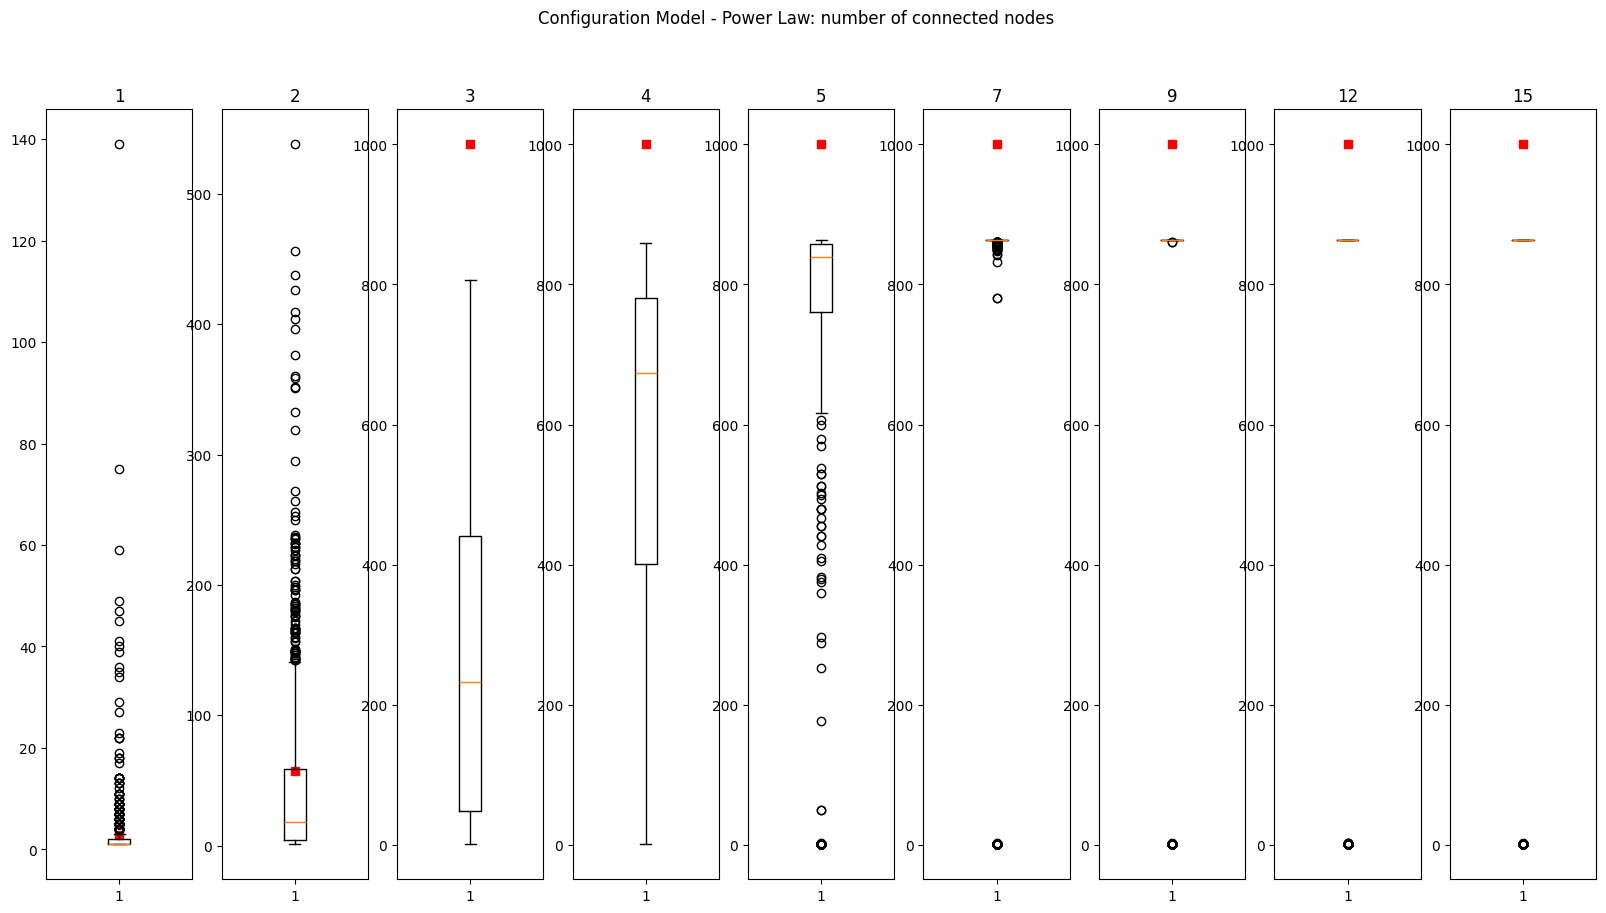

In [132]:
fig, ax = plt.subplots(1,len(times), figsize=(20,10))
for i in range(len(times)):
    ax[i].boxplot(list_number_connected_nodes_cm[i])
    ax[i].scatter(1, list_shell_cm[i], color='r', marker='s')
    ax[i].set_title(str(times[i]))
fig.suptitle('Configuration Model - Power Law: number of connected nodes')
plt.show()